In [67]:
import math
import pandas as pd
import matplotlib

In [68]:
rosnace = pd.DataFrame({
    '$U$ (kV)': [
        3.51, 3.90,  4.30,  4.71,  5.09,
        5.50, 5.94,  6.30,  6.70,  7.11,
        7.50, 7.92,  8.29,  8.69,  9.10,
        9.50, 9.90, 10.30, 10.69, 11.10,
    ],
    '$D_w$ (mm)': [
        22, 20, 17, 19, 17, 17, 16, 16, 14, 13,
        14, 13, 14, 13, 14, 13, 13, 12, 12, 12,
    ],
    '$D_z$ (mm)': [
        28, 28, 27, 25, 20, 23, 22, 21, 20, 19,
        18, 18, 18, 18, 18, 18, 17, 17, 17, 17,
    ]
})

In [69]:
malejace = pd.DataFrame({
    '$U$ (kV)': [
        11.10, 10.69, 10.30, 9.89, 9.50,
         9.10,  8.70,  8.30, 7.89, 7.50,
         7.10,  6.71,  6.33, 5.90, 5.50,
         5.12,  4.71,  4.31, 3.89, 3.49,
    ],
    '$D_w$ (mm)': [
        14, 14, 14, 14, 14, 15, 14, 15, 15, 15,
        16, 16, 17, 18, 20, 19, 19, 21, 20, 22,
    ],
    '$D_z$ (mm)': [
        16, 17, 16, 18, 18, 18, 18, 18, 19, 19,
        19, 19, 20, 23, 24, 25, 25, 27, 27, 29,
    ]
})

In [70]:
#df, filename = rosnace, 'sprawozdanie/wykres_A.pdf'
df, filename = malejace, 'sprawozdanie/wykres_B.pdf'

In [71]:
df.index += 1

In [72]:
niepewnosc_D = 1

In [73]:
def uzupelnij_ramki(df):
    # dodaj średnicę
    df['$D$ (mm)'] = df[['$D_z$ (mm)', '$D_w$ (mm)']].mean(axis=1)

    # dodaj odwrotność pierwiastka napięcia
    df[r'$X$ ($\frac{1}{\sqrt{kV}}$)'] = 1/df['$U$ (kV)'].pow(0.5)

In [74]:
def niepewnosc_X(U):
    return 0.09/(2 * math.sqrt(3) * math.sqrt(U**3))

In [75]:
uzupelnij_ramki(df)

In [76]:
import scipy.odr as odr
linear = odr.polynomial(1)
odr_res = (
    odr.ODR(
        odr.RealData(
            df[r'$X$ ($\frac{1}{\sqrt{kV}}$)'],
            df['$D$ (mm)'],
            sx=df[r'$U$ (kV)'].apply(niepewnosc_X),
            sy=[niepewnosc_D]*20,
        ),
        linear)
    .run()
)
b, a = odr_res.beta

In [77]:
std_b, std_a = odr_res.sd_beta
print(f'a = {a} ± {std_a} \nb = {b} ± {std_b}')

a = 46.66100259897096 ± 2.274920005763129 
b = 0.6582789906088176 ± 0.8906599787435814


In [78]:
def get_fit_xy():
    series = df[r'$X$ ($\frac{1}{\sqrt{kV}}$)']
    x = [series.min(), series.max()]
    y = [a*x_ + b for x_ in x]
    return (x, y)
print(get_fit_xy())

([0.3001501125938321, 0.5352877275721892], [14.663584174431044, 25.635341038051997])


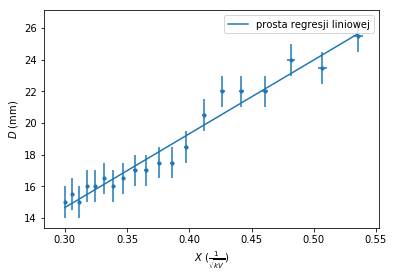

In [79]:
ax = df.plot(
    kind='scatter',
    s=10,  # "thickness" of points
    y='$D$ (mm)',
    x=r'$X$ ($\frac{1}{\sqrt{kV}}$)',
    xerr=df[r'$U$ (kV)'].apply(niepewnosc_X),
    yerr=niepewnosc_D,
)
x, y = get_fit_xy()
reg = pd.DataFrame(data={'prosta regresji liniowej': y}, index=x)
reg.plot(ax=ax)
matplotlib.pyplot.savefig(filename)

In [80]:
a = 46.1
ua = 1.7
# zdefiniujmy potrzebne stałe fizyczny i inne wartości
r = 127  # (mm) ± 3 mm; odlgegłość folia-ekran; wzięte z instrukcji
h = 6.62 # (J*s); stała Plancka; https://pl.wikipedia.org/wiki/Sta%C5%82a_Plancka
m = 9.11 * 10**(-31) # (kg); masa spoczynkowa elektronu; D. Halliday, R. Resnick, Fizyka, Tom 2
e = 1.60 * 10**(-19) # (C); ładunek elektronu

In [81]:
d = (r * h)/(a) * math.sqrt(2/(m*e))

In [82]:
def niepewnosc_d(r, h, a, m, e, ur, uh, ua, um, ue):
    niepewnosci = [ur, uh, ua, um, ue]
    niepewnosci_w_kwadratach = [u**2 for u in niepewnosci]
    
    ulamki = [
        2 * h**2 / (m * e * a**2),
        2 * r**2 / (m * e * a**2),
        2 * h**2 * r**2 / (m * e * a**4),
        h**2 * r**2 / (2 * e * a**2 * m**3),
        h**2 * r**2 / (2 * m * a**2 * e**3),
    ]
    
    return math.sqrt(sum(a * b for a, b in zip(ulamki, niepewnosci_w_kwadratach)))

In [83]:
dziwna_jednostka = 0.04472 # w metrach

In [84]:
niepewnosc_d(
    127, 6.626070040 * 10**(-34), a, 9.10938356 * 10**(-31), 1.6021766208 * 10**(-19),
    3, 0.000000081 * 10**(-34),  ua, 0.00000011 * 10**(-31), 0.0000000098 * 10**(-19),
) * dziwna_jednostka

1.8311440172431663e-11

In [64]:
r, h, a, m, e = 127, 6.626070040 * 10**(-34), a, 9.10938356 * 10**(-31), 1.6021766208 * 10**(-19)

In [65]:
d = r*h/a * math.sqrt(2/(m*e))

In [66]:
d * dziwna_jednostka

3.061719848965038e-10